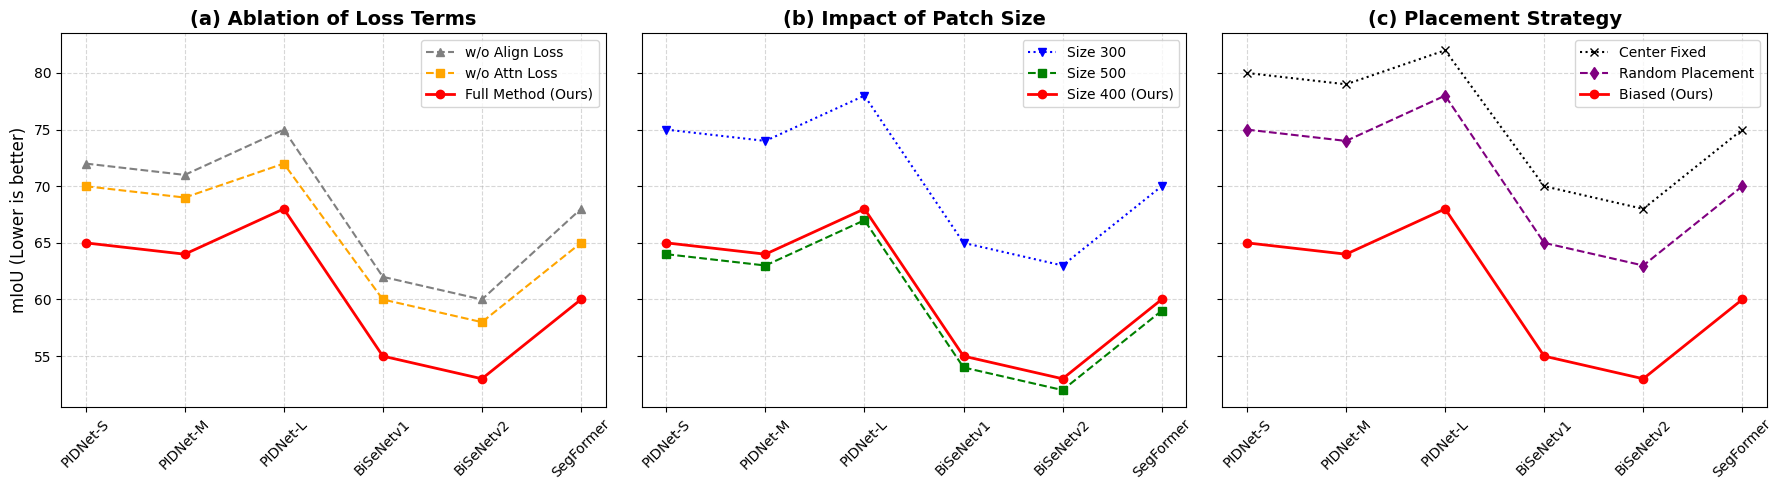

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA SETUP (Mock Data based on your ablation points) ---
models = ['PIDNet-S', 'PIDNet-M', 'PIDNet-L', 'BiSeNetv1', 'BiSeNetv2', 'SegFormer']
x = np.arange(len(models))

# Mock Data: mIoU values (Lower is better for attack)
# 1. LOSS ABLATION DATA
full_method = [65, 64, 68, 55, 53, 60]  # Your best method (Red line)
no_tv =       [67, 66, 70, 57, 55, 62]
no_attn =     [70, 69, 72, 60, 58, 65]
no_align =    [72, 71, 75, 62, 60, 68]

# 2. PATCH SIZE DATA
size_300 =    [75, 74, 78, 65, 63, 70]
size_400 =    [65, 64, 68, 55, 53, 60]  # (Same as full method)
size_500 =    [64, 63, 67, 54, 52, 59]  # Diminishing returns

# 3. PLACEMENT DATA
center_fixed = [80, 79, 82, 70, 68, 75]
random_place = [75, 74, 78, 65, 63, 70]
biased_ours  = [65, 64, 68, 55, 53, 60] # (Same as full method)

# --- PLOTTING ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True) # Wide figure, 3 cols

# PLOT 1: LOSS TERMS
ax = axes[0]
ax.plot(models, no_align, marker='^', linestyle='--', label='w/o Align Loss', color='gray')
ax.plot(models, no_attn, marker='s', linestyle='--', label='w/o Attn Loss', color='orange')
ax.plot(models, full_method, marker='o', linestyle='-', linewidth=2, label='Full Method (Ours)', color='red')
ax.set_title('(a) Ablation of Loss Terms', fontsize=14, fontweight='bold')
ax.set_ylabel('mIoU (Lower is better)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
ax.tick_params(axis='x', rotation=45)

# PLOT 2: PATCH SIZES
ax = axes[1]
ax.plot(models, size_300, marker='v', linestyle=':', label='Size 300', color='blue')
ax.plot(models, size_500, marker='s', linestyle='--', label='Size 500', color='green')
ax.plot(models, size_400, marker='o', linestyle='-', linewidth=2, label='Size 400 (Ours)', color='red')
ax.set_title('(b) Impact of Patch Size', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
ax.tick_params(axis='x', rotation=45)

# PLOT 3: PLACEMENT
ax = axes[2]
ax.plot(models, center_fixed, marker='x', linestyle=':', label='Center Fixed', color='black')
ax.plot(models, random_place, marker='d', linestyle='--', label='Random Placement', color='purple')
ax.plot(models, biased_ours, marker='o', linestyle='-', linewidth=2, label='Biased (Ours)', color='red')
ax.set_title('(c) Placement Strategy', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

\section{Introduction \& Related Work}

Semantic segmentation is a foundational perception task in autonomous driving, essential for providing the dense scene understanding required for safe planning and control. However, deep neural networks are inherently vulnerable to adversarial examples—imperceptible perturbations that cause catastrophic model failure. Investigating these vulnerabilities is not merely an adversarial exercise but a prerequisite for developing robust systems capable of withstanding real-world noise and malicious interference. While adversarial attacks have been extensively studied in image classification, their application to the more complex domain of semantic segmentation remains a critical area of research.

Despite recent progress in segmentation attacks~\cite{DBLP:journals/corr/abs-2111-11368,jia2023transegpgdimprovingtransferabilityadversarial,he2024transferable}, significant limitations persist in their practical applicability. The majority of existing methods generate image-wide perturbations, which modify every pixel in the scene. While theoretically effective, these global perturbations are impractical for physical deployment in dynamic driving environments. In contrast, adversarial patches—localized, universal patterns that can be printed and placed in the scene—offer a physically deployable threat model that poses a tangible risk to autonomous systems.

Furthermore, adversarial transferability in semantic segmentation is particularly underexplored across fundamentally different architectures. Convolutional Neural Networks (CNNs), with their strong locality and edge-based inductive biases, exhibit distinct failure modes compared to Vision Transformers (ViTs), which rely on global attention mechanisms~\cite{Mahmood2021Robust,Mo2022AdvTraining,PatchFool2025,Islam2025Mechanistic}. Prior work has largely focused on within-architecture transfer or classification tasks. To the best of our knowledge, no existing work has successfully addressed the challenge of transferring a universal adversarial patch from ViT to CNN architectures in the context of semantic segmentation.

We address this gap with \textbf{TransPatch}, a training framework for learning a single, physically deployable patch that is effective across diverse images and transferrable between ViT and CNN architectures. TransPatch first exploits the inherent sensitivity of ViTs to destabilize global context, then enforces transferability to CNNs through ensemble training with gradient alignment. To maximize impact, we utilize class-wise predictive entropy from the surrogate model to identify the most vulnerable semantic classes, biasing patch placement toward these high-risk regions rather than arbitrary locations.

Adversarial transferability in semantic segmentation remains particularly underexplored across fundamentally different architectures. While Convolutional Neural Networks (CNNs) exhibit strong locality and edge-based inductive biases that can mask global perturbations, Vision Transformers (ViTs) have been shown to be significantly more vulnerable to adversarial attacks due to their reliance on global attention mechanisms~\citep{Mahmood2021Robust,Mo2022AdvTraining,PatchFool2025,Islam2025Mechanistic}. This structural fragility suggests that ViTs can serve as highly effective surrogate models for generating potent adversarial features. However, prior research has predominantly focused on classification tasks or within-architecture transfer (e.g., CNN$\to$CNN), leaving the cross-architectural domain largely untouched. To the best of our knowledge, no existing work has successfully addressed the challenge of transferring universal adversarial patches from ViT to CNN architectures in semantic segmentation. Consequently, effective frameworks that leverage the sensitivity of ViTs to craft transferable attacks against robust CNN targets remain absent from the literature.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import torch
import torch.nn.functional as F
import numpy as np
import gc
from copy import deepcopy
from tqdm import tqdm

# --- 1. Cityscapes Visualization Helpers ---
CITYSCAPES_LABELS = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

# Standard Cityscapes Palette (RGB)
CITYSCAPES_PALETTE = np.array([
    [128, 64, 128],  # 0: road
    [244, 35, 232],  # 1: sidewalk
    [70, 70, 70],    # 2: building
    [102, 102, 156], # 3: wall
    [190, 153, 153], # 4: fence
    [153, 153, 153], # 5: pole
    [250, 170, 30],  # 6: traffic light
    [220, 220, 0],   # 7: traffic sign
    [107, 142, 35],  # 8: vegetation
    [152, 251, 152], # 9: terrain
    [70, 130, 180],  # 10: sky
    [220, 20, 60],   # 11: person
    [255, 0, 0],     # 12: rider
    [0, 0, 142],     # 13: car
    [0, 0, 70],      # 14: truck
    [0, 60, 100],    # 15: bus
    [0, 80, 100],    # 16: train
    [0, 0, 230],     # 17: motorcycle
    [119, 11, 32]    # 18: bicycle
])

def colorize_mask(mask):
    """
    Converts a single-channel mask (H, W) with values 0-18 
    into a 3-channel RGB image (H, W, 3).
    """
    # Map valid classes to palette, 255 (ignore) maps to black
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label_id in range(len(CITYSCAPES_PALETTE)):
        color_mask[mask == label_id] = CITYSCAPES_PALETTE[label_id]
    return color_mask

def plot_visualization(image_tensor, label_tensor, preds_dict, mean, std):
    """
    Plots Input, GT, and 7 Model Predictions in a grid with a legend.
    """
    # Denormalize Image
    mean_view = torch.tensor(mean).view(3, 1, 1).to(image_tensor.device)
    std_view = torch.tensor(std).view(3, 1, 1).to(image_tensor.device)
    img_vis = image_tensor * std_view + mean_view
    img_vis = torch.clamp(img_vis, 0, 1).permute(1, 2, 0).cpu().numpy()

    # Prepare Grid: 3x3 (Total 9 plots: 1 Image + 1 GT + 7 Models)
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    axes = axes.flatten()

    # 1. Original Patched Image
    axes[0].imshow(img_vis)
    axes[0].set_title("Input (Patched)", fontsize=14, weight='bold')
    axes[0].axis('off')

    # 2. Ground Truth
    gt_color = colorize_mask(label_tensor.cpu().numpy())
    axes[1].imshow(gt_color)
    axes[1].set_title("Ground Truth", fontsize=14, weight='bold')
    axes[1].axis('off')

    # 3. Model Predictions
    model_names = list(preds_dict.keys())
    for i, name in enumerate(model_names):
        ax_idx = i + 2 # Start from 3rd subplot
        if ax_idx < len(axes):
            pred_mask = preds_dict[name].cpu().numpy()
            pred_color = colorize_mask(pred_mask)
            axes[ax_idx].imshow(pred_color)
            axes[ax_idx].set_title(f"Pred: {name}", fontsize=12)
            axes[ax_idx].axis('off')

    # Create Legend (using dummy patches)
    legend_patches = [patches.Patch(color=CITYSCAPES_PALETTE[i]/255.0, label=f"{i}: {label}") 
                      for i, label in enumerate(CITYSCAPES_LABELS)]
    
    # Place legend outside the plot
    fig.legend(handles=legend_patches, loc='center right', title="Cityscapes Classes", 
               bbox_to_anchor=(1.15, 0.5), fontsize='small')
    
    plt.tight_layout()
    plt.show()


# --- 2. Main Execution Block ---

# Config & Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_standard = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_standard = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Metrics Initialization
metrics = {
    'PIDNet-L': SegmentationMetric(config),
    'PIDNet-M': SegmentationMetric(config),
    'PIDNet-S': SegmentationMetric(config),
    'ICNet': SegmentationMetric(config),
    'BiSeNetV1': SegmentationMetric(config),
    'BiSeNetV2': SegmentationMetric(config),
    'SegFormer': SegmentationMetric(config),
}

for m in metrics.values(): m.reset()

# Using the specific patch requested
patch_key = 'pidnet_s' 
current_patch = adversarial_patch['pidnet_s'] 
# print(f'Starting evaluation with patch optimized for: {patch_key}')

# Flag to ensure we only plot once
has_plotted = False 

# Iterate Dataloader
for iter, batches in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
    image_standard, label, _, _, idx = batches
    
    # Move to device
    image_standard = image_standard.to(device)
    label = label.to(device)
    sidewalk_coords[iter] = sidewalk_coords[iter].to(device)
    
    # --- Apply Patch ---
    # Clone to avoid modifying original if needed elsewhere, though here we overwrite
    image_patched = image_standard.clone() 
    
    if len(sidewalk_coords[iter]) != 0:
        x1, y1, x2, y2 = sidewalk_coords[iter]
        # Apply patch to image
        image_patched[:, :, y1:y2, x1:x2] = current_patch

    # Dictionary to store predictions for visualization (current batch only)
    current_batch_preds = {}

    # --- Model Inference & Metric Update ---
    
with torch.no_grad():
        size = label.shape

        # 1. PIDNet-L
        outputs = pidnet_l(image_patched)
        out = F.interpolate(outputs[config.test.output_index_pidnet], size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['PIDNet-L'].update(out, label)
        current_batch_preds['PIDNet-L'] = pred_mask[0] # Save first image in batch for plot

        # 2. PIDNet-M
        outputs = pidnet_m(image_patched)
        out = F.interpolate(outputs[config.test.output_index_pidnet], size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['PIDNet-M'].update(out, label)
        current_batch_preds['PIDNet-M'] = pred_mask[0]

        # 3. PIDNet-S
        outputs = pidnet_s(image_patched)
        out = F.interpolate(outputs[config.test.output_index_pidnet], size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['PIDNet-S'].update(out, label)
        current_batch_preds['PIDNet-S'] = pred_mask[0]

        # 4. ICNet
        outputs = icnet(image_patched)
        out = outputs[config.test.output_index_icnet] # ICNet usually outputs resized
        # Ensure resizing if ICNet output isn't original size
        if out.shape[-2:] != size[-2:]:
             out = F.interpolate(out, size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['ICNet'].update(out, label)
        current_batch_preds['ICNet'] = pred_mask[0]

        # 5. BiSeNetV1
        outputs = bisenetv1(image_patched)
        out = outputs[config.test.output_index_bisenet]
        if out.shape[-2:] != size[-2:]:
             out = F.interpolate(out, size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['BiSeNetV1'].update(out, label)
        current_batch_preds['BiSeNetV1'] = pred_mask[0]

        # 6. BiSeNetV2
        outputs = bisenetv2(image_patched)
        out = outputs[config.test.output_index_bisenet]
        if out.shape[-2:] != size[-2:]:
             out = F.interpolate(out, size[-2:], mode='bilinear', align_corners=True)
        pred_mask = out.argmax(dim=1)
        metrics['BiSeNetV2'].update(out, label)
        current_batch_preds['BiSeNetV2'] = pred_mask[0]

        # 7. Segformer (Loaded individually to save memory as per original snippet)
        segformer = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"
        ).to(device)
        segformer.eval()
        with torch.no_grad():
            outputs = segformer(image_patched)
            out = F.interpolate(outputs.logits, size[-2:], mode='bilinear', align_corners=True)
            pred_mask = out.argmax(dim=1)
            metrics['SegFormer'].update(out, label)
            current_batch_preds['SegFormer'] = pred_mask[0]
        
        del segformer
    
    # --- Trigger Visualization (Only once) ---
    # We check if a patch existed in this image to make the plot meaningful
        if not has_plotted and len(sidewalk_coords[iter]) != 0:
            print(f"Generating visualization for Iteration {iter}...")
            plot_visualization(
                image_patched[0],      # First image in batch
                label[0],              # First label in batch
                current_batch_preds,   # Preds for first image
                mean_standard, 
                std_standard
            )
            has_plotted = True
    
        # Memory Cleanup
        del image_standard, label, image_patched, outputs, out
        gc.collect()
        torch.cuda.empty_cache()

# --- 3. Final Metrics Output ---
print("\n--- Final Evaluation Metrics (mIoU) ---")
results = {}
for name, metric in metrics.items():
    # Assuming .get() returns (pixAcc, mIoU) based on standard utils
    miou = metric.get()[1] 
    results[name] = miou
    print(f"{name:<15}: {miou:.4f}")